In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score, precision_score, accuracy_score
from helper import wrap_labels


In [2]:
df = pd.read_csv('data/final_data.csv', sep=',')

In [3]:
df = df.drop(["Unnamed: 0"], axis=1)

In [4]:
df.head()

,Home Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,...,Away Team On Target Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Red Cards,Full Time Result
0,40,5.0,3.0,5.0,13.0,69.0,11.0,16.0,13.0,3.0,...,5.0,4.0,22.0,84.0,17.0,14.0,9.0,3.0,0.0,0
1,47,4.0,3.0,3.0,20.0,76.0,13.0,16.0,23.0,4.0,...,1.0,3.0,27.0,79.0,14.0,16.0,8.0,2.0,1.0,1
2,53,6.0,3.0,5.0,25.0,79.0,20.0,21.0,13.0,1.0,...,1.0,3.0,30.0,76.0,10.0,14.0,26.0,3.0,0.0,0
3,56,7.0,6.0,11.0,26.0,81.0,19.0,25.0,8.0,3.0,...,2.0,7.0,19.0,70.0,11.0,20.0,9.0,3.0,0.0,1
4,41,5.0,5.0,5.0,28.0,60.0,29.0,17.0,13.0,4.0,...,4.0,6.0,36.0,75.0,25.0,20.0,14.0,1.0,0.0,0


# Machine Learning  Baseline Models

In [5]:
# Test train data split
X = df.drop("Full Time Result", axis=1)
y = df["Full Time Result"]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)

In [6]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='weighted'),
                 'recall': make_scorer(recall_score, average='weighted'),
                 }

### Naive bayes model

In [62]:
np.random.seed(42)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print(classification_report(y_test, y_pred_gnb))
gnb_report = classification_report(y_test, y_pred_gnb, output_dict=True)
cv_gnb = cross_validate(gnb, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       247
           1       0.35      0.40      0.37       110
           2       0.71      0.58      0.64       175

    accuracy                           0.63       532
   macro avg       0.59      0.58      0.58       532
weighted avg       0.64      0.63      0.63       532



### Decision tree model

In [8]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

print(classification_report(y_test, y_pred_dtc))
dtc_report = classification_report(y_test, y_pred_dtc, output_dict=True)
cv_dtc = cross_validate(dtc, X, y, cv=5, scoring=custom_scorer)


              precision    recall  f1-score   support

           0       0.65      0.67      0.66       247
           1       0.26      0.37      0.31       110
           2       0.59      0.42      0.49       175

    accuracy                           0.52       532
   macro avg       0.50      0.49      0.49       532
weighted avg       0.55      0.52      0.53       532



### Random forest model

In [9]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
rfc_report = classification_report(y_test, y_pred_rfc, output_dict=True)
cv_rfc = cross_validate(rfc, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       247
           1       0.45      0.31      0.37       110
           2       0.73      0.61      0.66       175

    accuracy                           0.67       532
   macro avg       0.62      0.60      0.60       532
weighted avg       0.65      0.67      0.65       532



### Logistic Regression model

In [52]:
mm_scaler = sklearn.preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_s = mm_scaler.transform(X_train)
X_test_s = mm_scaler.transform(X_test)

In [54]:
lr = LogisticRegression(random_state=42, max_iter=2800)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
print(classification_report(y_test, y_pred_lr))
cv_lr=cross_validate(lr, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       247
           1       0.45      0.27      0.34       110
           2       0.75      0.66      0.70       175

    accuracy                           0.68       532
   macro avg       0.63      0.60      0.60       532
weighted avg       0.66      0.68      0.66       532



### KNN model with normalization

In [11]:
X_normalized = sklearn.preprocessing.normalize(X, norm='l2')
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
X_normalized, y, test_size=0.20, random_state=42)

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train_n,y_train_n)
y_pred_knn = knn.predict(X_test_n)
knn_report = classification_report(y_test, y_pred_knn, output_dict=True)
print(classification_report(y_test_n, y_pred_knn))
cv_knn = cross_validate(knn, X_normalized, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.57      0.77      0.66       247
           1       0.26      0.25      0.26       110
           2       0.57      0.31      0.40       175

    accuracy                           0.51       532
   macro avg       0.47      0.44      0.44       532
weighted avg       0.51      0.51      0.49       532



# Base Model comparison

In [13]:
labels = ['Bayes', 'Drzewo Decyzyjne', 'Las Losowy','Regresja Logistyczna', 'KNN']

In [14]:
# # Replacing all cross-validation scores for all models with a mean of that score
# cvs = [cv_gnb, cv_dtc, cv_rfc, cv_lr, cv_knn]
# for cv in cvs:
#     for key in cv.keys():
#         cv[key] = round(np.mean(cv[key]),2)

In [15]:
# # Creating dictionaries for precision, recall and accuracy where key = model name, value = mean
#
# avg_precision = {}
# avg_recall = {}
# avg_accuracy = {}
# for cv,label in zip(cvs,labels):
#     avg_precision[label] = cv['test_precision']
#     avg_accuracy[label] = cv['test_accuracy']
#     avg_recall[label] = cv['test_recall']

In [16]:
reports_base = [gnb_report, dtc_report, rfc_report,lr_report,knn_report]

c0_precision = {}
c1_precision = {}
c2_precision = {}

c0_recall = {}
c1_recall = {}
c2_recall = {}

accuracy = {}
precision = {}
recall = {}
for report,label in zip(reports_base, labels):
    c0_precision[label] = round(report['0']['precision'],3)
    c1_precision[label] = round(report['1']['precision'],3)
    c2_precision[label] = round(report['2']['precision'],3)
    c0_recall[label] = round(report['0']['recall'],3)
    c1_recall[label] = round(report['1']['recall'],3)
    c2_recall[label] = round(report['2']['recall'],3)
    accuracy[label] = round(report['accuracy'],3)
    precision[label] = round(report['macro avg']['precision'],3)
    recall[label] = round(report['macro avg']['recall'],3)

### Accuracy

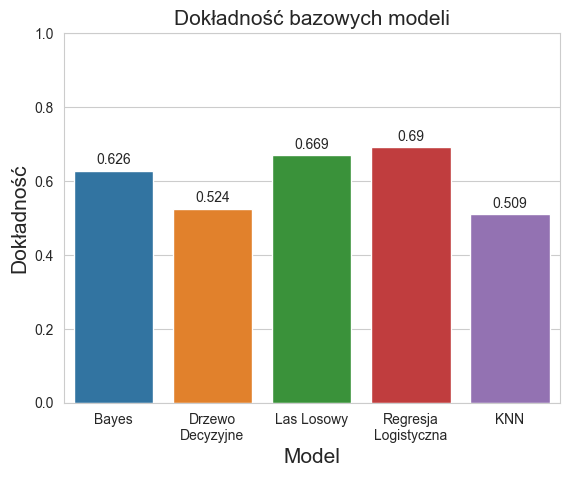

In [17]:
ax = sns.barplot(x=list(accuracy.keys()), y=list(accuracy.values()))
for i in ax.containers:
    ax.bar_label(i, padding=3)
plt.ylim(0.0,1.0)
plt.title("Dokładność bazowych modeli",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Dokładność",fontsize=15)
wrap_labels(ax, 10)

### Precision

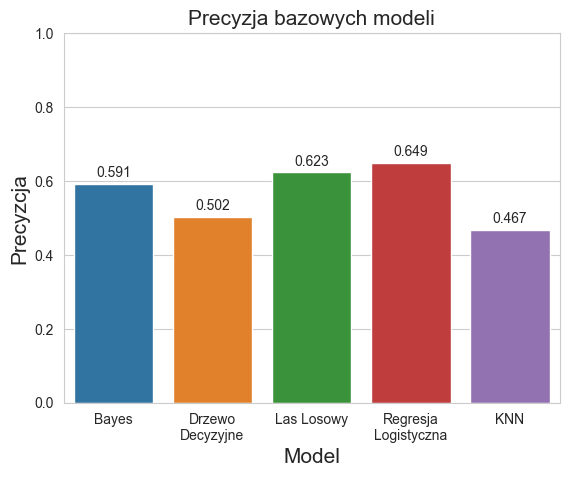

In [18]:
ax = sns.barplot(x=list(precision.keys()), y=list(precision.values()))
for i in ax.containers:
    ax.bar_label(i, padding=3)
plt.ylim(0.0,1.0)
plt.title("Precyzja bazowych modeli",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precyzcja",fontsize=15)
wrap_labels(ax, 10)

### Czułość

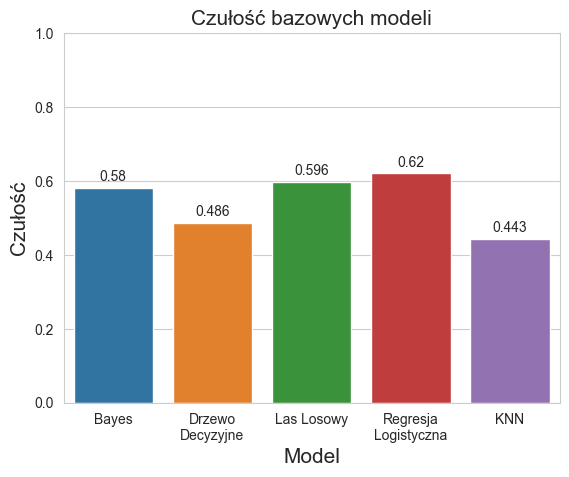

In [19]:
ax = sns.barplot(x=list(recall.keys()), y=list(recall.values()))
for i in ax.containers:
    ax.bar_label(i, padding=3)
plt.ylim(0.0,1.0)
plt.title("Czułość bazowych modeli",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Czułość",fontsize=15)
wrap_labels(ax, 10)

## Class 0 - Home Win  analysis

### Precision

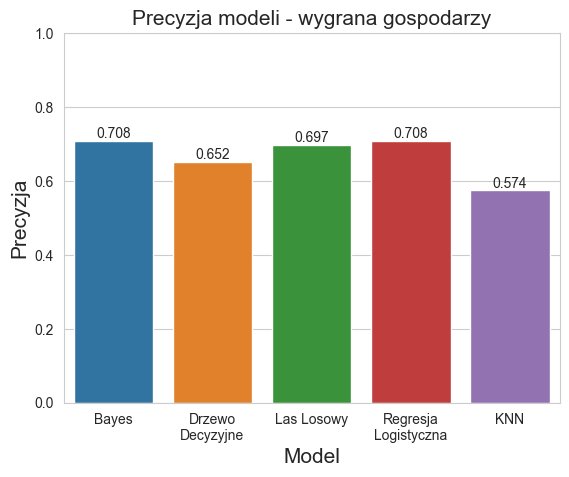

In [20]:
ax = sns.barplot(x=list(c0_precision.keys()), y=list(c0_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Precyzja modeli - wygrana gospodarzy",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precyzja",fontsize=15)
wrap_labels(ax, 10)

### Recall

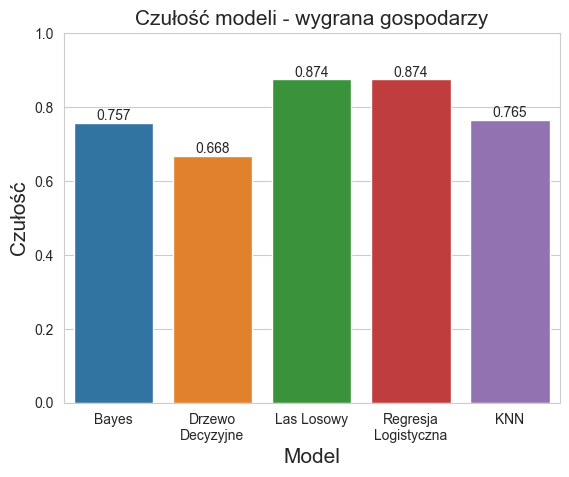

In [21]:
ax = sns.barplot(x=list(c0_recall.keys()), y=list(c0_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Czułość modeli - wygrana gospodarzy",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Czułość",fontsize=15)
wrap_labels(ax, 10)

## Class 1 - Draw analysis

### Precision

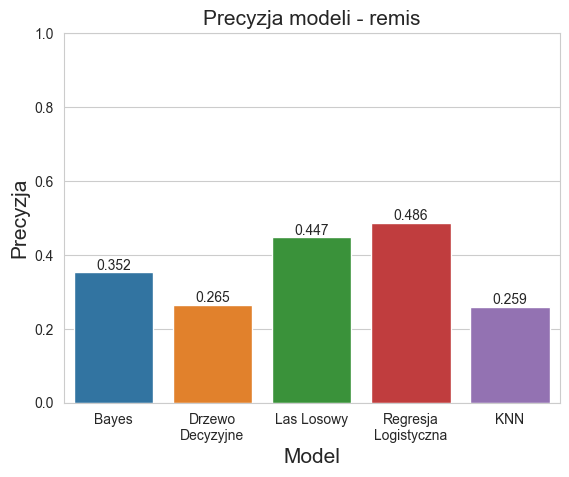

In [22]:
ax = sns.barplot(x=list(c1_precision.keys()), y=list(c1_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Precyzja modeli - remis",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precyzja",fontsize=15)
wrap_labels(ax, 10)

### Recall

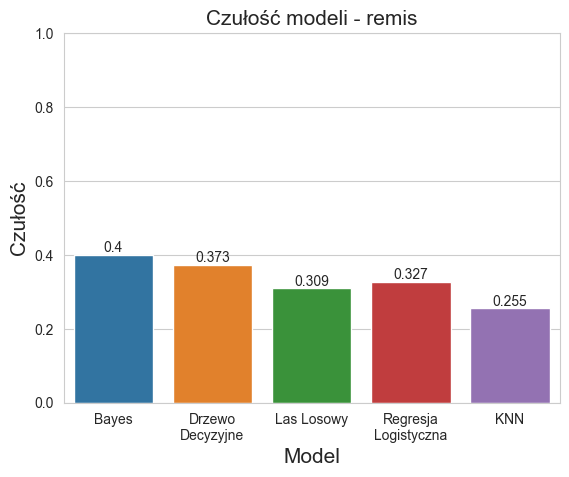

In [23]:
ax = sns.barplot(x=list(c1_recall.keys()), y=list(c1_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Czułość modeli - remis",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Czułość",fontsize=15)
wrap_labels(ax, 10)

## Class 2 - Away Win analysis

### Precision

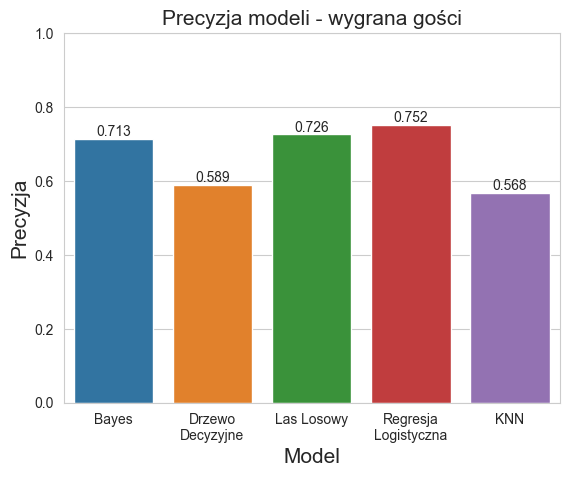

In [24]:
ax = sns.barplot(x=list(c2_precision.keys()), y=list(c2_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Precyzja modeli - wygrana gości",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precyzja",fontsize=15)
wrap_labels(ax, 10)

### Recall

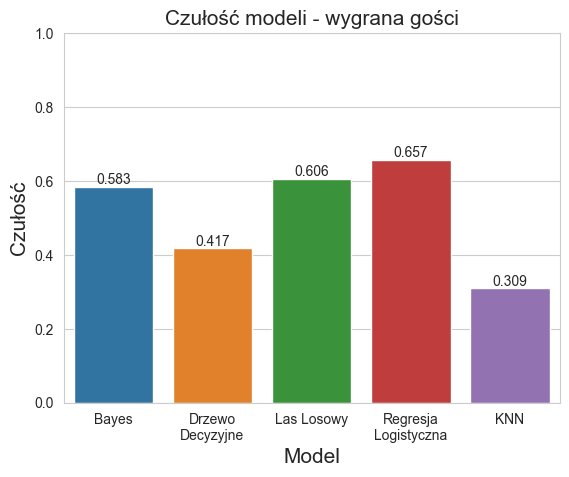

In [25]:
ax = sns.barplot(x=list(c2_recall.keys()), y=list(c2_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Czułość modeli - wygrana gości",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Czułość",fontsize=15)
wrap_labels(ax, 10)

# Tuning Hyperparameters

### Decision Tree tuning

In [90]:
dtc_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None,1,2,3,4,5,10],
    'min_samples_split': [2,3,4],
    'min_samples_leaf':[1,2,3,4,5],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
} # final iteration of grid search params that resulted with finding the best score

dtc = DecisionTreeClassifier()
gs_dtc = GridSearchCV(estimator=dtc, param_grid=dtc_params,cv=5)

gs_dtc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4], 'random_state': [42]})

In [92]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42}

In [93]:
gs_y_pred = gs_dtc.predict(X_test)
print(classification_report(y_test, gs_y_pred))
dtc_report_tuned = classification_report(y_test, gs_y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.65      0.82      0.72       247
           1       0.78      0.06      0.12       110
           2       0.59      0.71      0.65       175

    accuracy                           0.63       532
   macro avg       0.67      0.53      0.50       532
weighted avg       0.66      0.63      0.57       532



### Random Forest Tuning

In [118]:
rfc_params ={
    'n_estimators': [400],
    'criterion': ['entropy'],
    'max_depth': [10],
    'min_samples_split': [2,3,4],
    'max_features': ['sqrt'],
    'random_state': [42]
} # final iteration of grid search params that resulted in finding the best score
rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(estimator=rfc,param_grid=rfc_params,cv=5)
gs_rfc.fit(X_train,y_train)
gs_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'n_estimators': 400,
 'random_state': 42}

In [119]:
rfc_y_pred = gs_rfc.predict(X_test)
print(classification_report(y_test,rfc_y_pred))
rfc_report_tuned = classification_report(y_test,rfc_y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       247
           1       0.49      0.26      0.34       110
           2       0.75      0.64      0.69       175

    accuracy                           0.68       532
   macro avg       0.64      0.60      0.60       532
weighted avg       0.67      0.68      0.66       532



### Logistic Regression Tuning

In [57]:
lr_params = {
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'max_iter': [ 200, 1000, 1500,2500,2800, 3000,3500],
    'random_state': [42]
} # final iteration of grid search params that resulted in finding the best score
lr = LogisticRegression()
gs_lr = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, verbose=1)
gs_lr.fit(X_train_s, y_train)
gs_lr.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


{'max_iter': 200, 'random_state': 42, 'solver': 'newton-cg'}

In [56]:
lr_y_pred = gs_lr.predict(X_test_s)
print(classification_report(y_test,lr_y_pred))
lr_report_tuned =  classification_report(y_test,lr_y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       247
           1       0.45      0.27      0.34       110
           2       0.75      0.66      0.70       175

    accuracy                           0.68       532
   macro avg       0.63      0.60      0.60       532
weighted avg       0.66      0.68      0.66       532



### KNN Tuning

In [69]:
knn_params ={
    'n_neighbors': list(range(25,50)),
    'weights': ['uniform', 'distance'],
    'p': [1,2]
} # final iteration of grid search params that resulted in finding the best score
knn = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator=knn, param_grid=knn_params, verbose=1)
gs_knn.fit(X_train_n, y_train_n)
gs_knn.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_neighbors': 45, 'p': 1, 'weights': 'distance'}

In [71]:
knn_y_pred = gs_knn.predict(X_test_n)
print(classification_report(y_test_n,knn_y_pred))
knn_report_tuned = classification_report(y_test_n,knn_y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.63      0.86      0.73       247
           1       0.34      0.20      0.25       110
           2       0.62      0.46      0.53       175

    accuracy                           0.59       532
   macro avg       0.53      0.51      0.50       532
weighted avg       0.57      0.59      0.56       532



# Tuned models comparison

In [82]:
reports_tuned = [gnb_report, dtc_report_tuned, rfc_report_tuned,lr_report_tuned,knn_report_tuned]

c0_precision_tuned = {}
c1_precision_tuned = {}
c2_precision_tuned = {}

c0_recall_tuned = {}
c1_recall_tuned = {}
c2_recall_tuned = {}

accuracy_tuned = {}
for report,label in zip(reports_tuned, labels):
    c0_precision[label] = round(report['0']['precision'],2)
    c1_precision[label] = round(report['1']['precision'],2)
    c2_precision[label] = round(report['2']['precision'],2)
    c0_recall[label] = round(report['0']['recall'],2)
    c1_recall[label] = round(report['1']['recall'],2)
    c2_recall[label] = round(report['2']['recall'],2)
    accuracy_tuned[label] = round(report['accuracy'],2)

NameError: name 'dtc_report_tuned' is not defined

## Class 0 - Home Win  analysis

### Precision

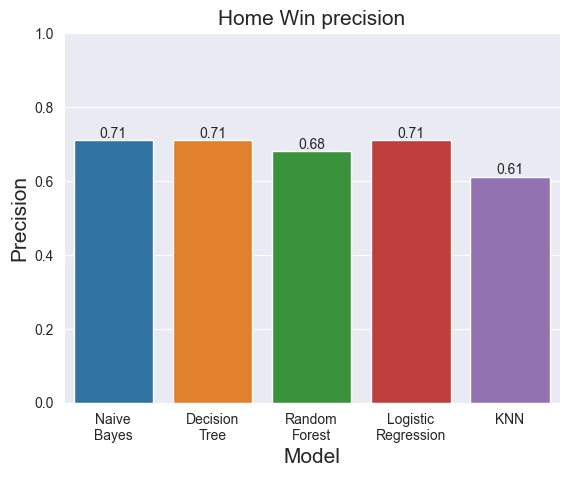

In [55]:
ax = sns.barplot(x=list(c0_precision.keys()), y=list(c0_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Home Win precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

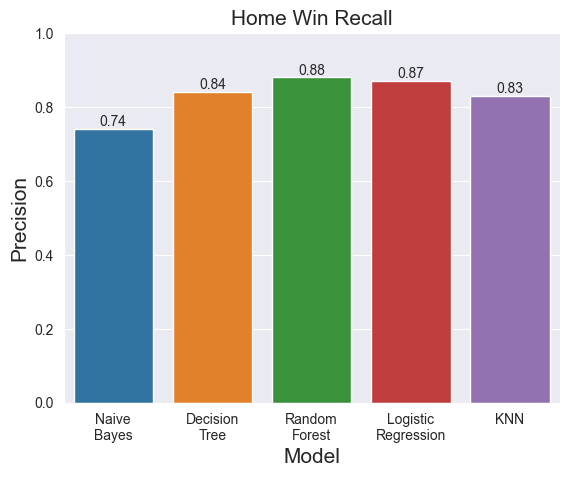

In [56]:
ax = sns.barplot(x=list(c0_recall.keys()), y=list(c0_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Home Win Recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Class 1 - Draw analysis

### Precision

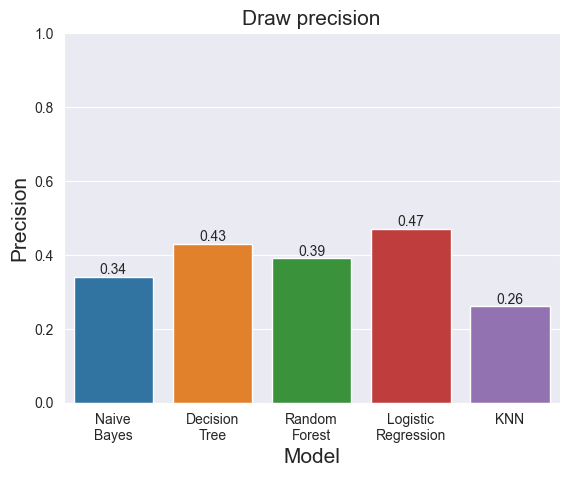

In [53]:
ax = sns.barplot(x=list(c1_precision.keys()), y=list(c1_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Draw precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

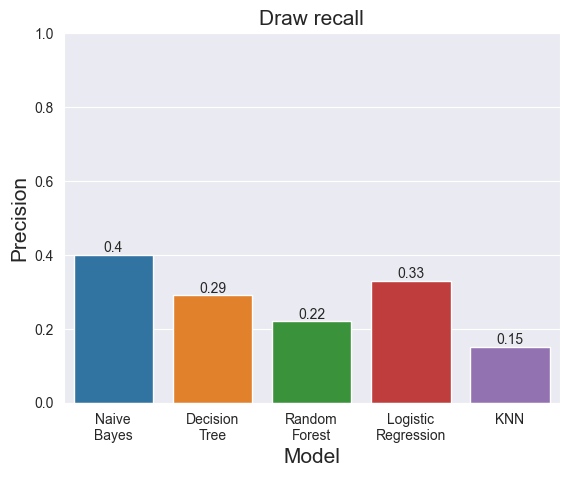

In [57]:
ax = sns.barplot(x=list(c1_recall.keys()), y=list(c1_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Draw recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Class 2 - Away win analysis

### Precision

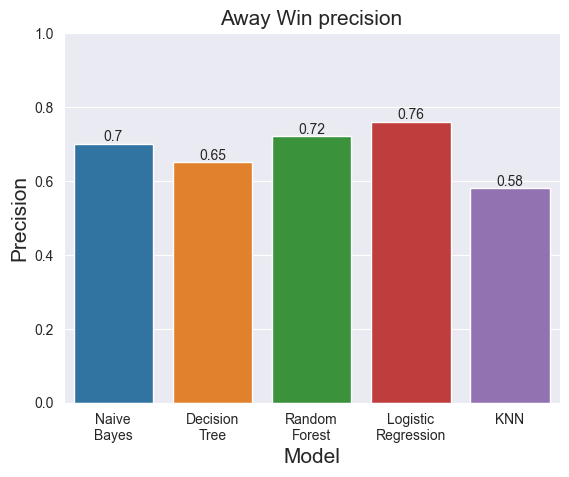

In [58]:
ax = sns.barplot(x=list(c2_precision.keys()), y=list(c2_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Away Win precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

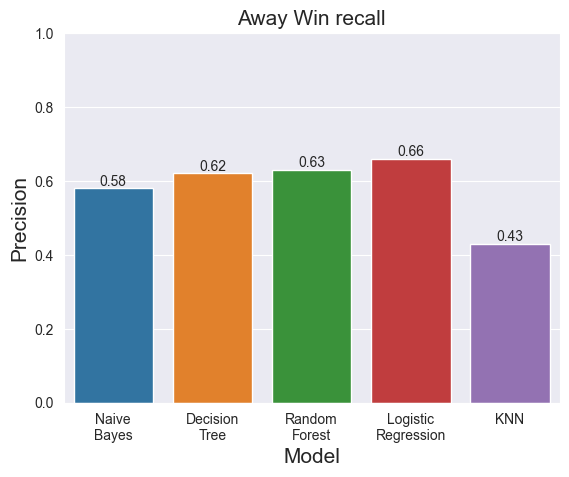

In [59]:
ax = sns.barplot(x=list(c2_recall.keys()), y=list(c2_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Away Win recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Tuned models accuracies comparison

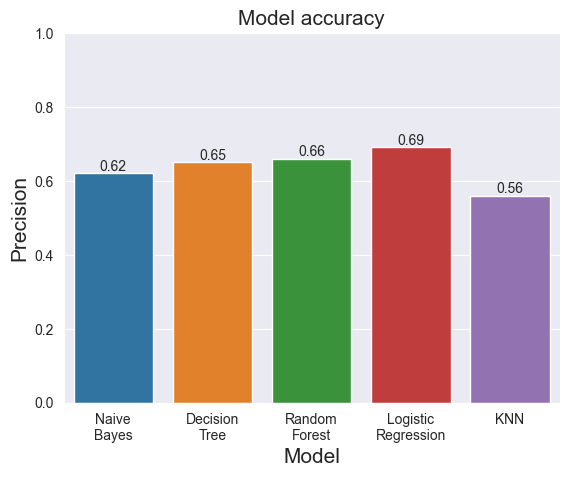

In [60]:
ax = sns.barplot(x=list(tuned_accuracy.keys()), y=list(tuned_accuracy.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Model accuracy",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)